# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2020.csv", encoding = 'utf-8')

ep_data = pd.read_csv("results/ep.csv", encoding = 'utf-8')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'utf-8')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'utf-8')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

In [5]:
for i in range(2012, 2021):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    if "ï»¿id" in drive.columns:
        drive["id"] = drive["ï»¿id"]
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    if "ï»¿id" in gm.columns:
        gm["id"] = gm["ï»¿id"]
    gm = gm[(gm.home_points.notnull()) & (gm.away_points.notnull())]
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    if "ï»¿id" in plys.columns:
        plys["id"] = plys["ï»¿id"]
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}") # 171692
print(f"Total Plays: {len(pbp_data)}") # 1210147

Total Games: 7165
Total Drives: 184612
Total Plays: 1304285


In [6]:
croot_data = pd.DataFrame()

for i in range(2007, 2021):
    k = retrieveCfbDataFile('recruiting',i)
    croot_data = croot_data.append(k, sort=False)
    
    
def calc_rolling_avg(frame, y):
    return frame[(frame.year == (y-3))| (frame.year == (y-2)) | (frame.year == (y-1)) | (frame.year == y)].rating.mean()
def calculate_fcs_talent(year):
    return croot_data[(croot_data.year == (yr-3))| (croot_data.year == (yr-2)) | (croot_data.year == (yr-1)) | (croot_data.year == yr)].rating.quantile(.02)
def calculate_roster_talent(team, year):
    team_slice = croot_data[(croot_data.committedTo == team)]
    if (len(team_slice) == 0):
        return calculate_fcs_talent(year)
    return calc_rolling_avg(team_slice, year)
print(f"Total Croots: {len(croot_data)}")

Total Croots: 44156


In [7]:
production = pd.DataFrame()
for i in range(2020, 2021):
    k = retrieveCfbDataFile('production',i)
    k['YEAR'] = i
    production = production.append(k, sort=False) 


def calculate_returning_production(team, yr):
    team_slice = production[(production.TEAM == team) & (production.YEAR == yr)]
    if (len(team_slice) == 0):
        return production[(production.YEAR == yr)].OVERALL_PCT.quantile(.02)
    return team_slice.OVERALL_PCT.to_list()[0]

# print(f"Georgia Tech: {calculate_returning_production('Georgia Tech', 2020)}")
production

,OVERALL_RANK,TEAM,OVERALL_PCT,OFFENSE_PCT,OFFENSE_RANK,DEFENSE_PCT,DEFENSE_RANK,YEAR
0,1,Northwestern,84,88,6,80,23,2020
1,2,Georgia Tech,84,74,39,94,2,2020
2,3,Houston,83,73,42,93,3,2020
3,4,East Carolina,83,87,8,79,26,2020
4,5,USC,82,77,25,87,7,2020
...,...,...,...,...,...,...,...,...
125,126,Kansas,42,41,115,44,117,2020
126,127,LSU,42,30,128,54,92,2020
127,128,Air Force,42,46,107,38,122,2020
128,129,UTEP,41,39,118,44,119,2020


In [8]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes',"ï»¿offense","drive_number","start_yards_to_goal","end_yards_to_goal"], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)


drives.loc[
    drives.defense == drives.away_team, ['offense']
] = drives.home_team

drives.loc[
    drives.defense == drives.home_team, ['offense']
] = drives.away_team

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

Clean Drives: 183527


In [9]:
drives[(drives.index < 170795)].isna().any()

index             False
offense           False
defense           False
game_id           False
drive_id          False
scoring           False
start_period      False
start_yardline    False
end_period        False
end_yardline      False
plays             False
yards             False
drive_result      False
year              False
away_team         False
home_team         False
dtype: bool

In [10]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [11]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush',
 'End of Regulation']

In [12]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
#     pbp_data.EqPPP.fillna(value=0, inplace=True)

print("EqPPP MAX:", pbp_data.EqPPP.max())
print("EqPPP MIN:", pbp_data.EqPPP.min())

EqPPP MAX: 4.973592175868585
EqPPP MIN: -2.940584903533729


In [13]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,ppa,year,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,-0.512082,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,-0.220409,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1.072268,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,NaN,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527


In [14]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [15]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,game_id,drive_number,play_number,offense_timeouts,defense_timeouts,yards_to_goal,scoring,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.142649,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810527,False,True


In [16]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff',"KickoffEqPPP","KickoffIsoPPP","PuntEqPPP","PuntIsoPPP","KickoffReturnEqPPP","KickoffReturnIsoPPP","PuntReturnEqPPP","PuntReturnIsoPPP"]

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        'Plays' : [len(team_off_plays)],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_ep(kick_yardline, distance, return_yards):
    return ep_data.iloc[max(min(100, int(kick_yardline + distance)), 0)].ep - ep_data.iloc[max(min(100, kick_yardline), 0)].ep - ep_data.iloc[max(min(100, int(return_yards)), 0)].ep

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net","EP"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = np.nan_to_num(tmp.values)
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
        kickoff_distance['EP'] = kickoff_distance.apply(lambda x: determine_kick_ep(kickoff_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    kick_eqppp = kickoff_distance[(kickoff_distance.Offense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Offense == team)]) > 0) else 0
    kick_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)].EP.mean()
    kick_ret_eqppp = kickoff_distance[(kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Defense == team)]) > 0) else 0
    kick_ret_isoppp = kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)].EP.mean() if (len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Defense == team)]) > 0) else 0
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful","EP"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = np.nan_to_num(pt_tmp.values)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        punt_distance['EP'] = punt_distance.apply(lambda x: determine_kick_ep(punt_plays.yard_line[x.Index], x.Distance, x.Return),axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    punt_eqppp = punt_distance[(punt_distance.Offense == team)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team)]) > 0) else 0
    punt_isoppp = punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Offense == team) & (punt_distance.Successful == True)]) > 0) else 0
    punt_ret_eqppp = punt_distance[(punt_distance.Defense == team)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team)]) > 0) else 0
    punt_ret_isoppp = punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)].EP.mean() if (len(punt_distance[(punt_distance.Defense == team) & (punt_distance.Successful == True)]) > 0) else 0
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'KickoffEqPPP' : [kick_eqppp],
        'KickoffIsoPPP' : [kick_isoppp],
        'KickoffReturnEqPPP' : [kick_ret_eqppp],
        'KickoffReturnIsoPPP' : [kick_ret_isoppp],
        
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr],
        'PuntEqPPP' : [punt_eqppp],
        'PuntIsoPPP' : [punt_isoppp],
        'PuntReturnEqPPP' : [punt_eqppp],
        'PuntReturnIsoPPP' : [punt_isoppp]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
#     print(team_stat_pack.IsoPPP)
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
#     return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)
    quant = (team_stat_pack.OffSRDiff * 0.37) + (team_stat_pack.ActualTODiff / team_stat_pack.Plays) * 0.21 + (team_stat_pack.KickoffEqPPP - team_stat_pack.KickoffReturnEqPPP) * 0.22 + (team_stat_pack.PuntEqPPP - team_stat_pack.PuntReturnEqPPP) * 0.20
    return translate(quant, -10, 10, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
#     return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    return translate(team_stat_pack.ExpTO - team_stat_pack.ActualTO, -5, 5, 0, 3.0) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3.0) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4.0)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)
def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            return None
#             game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
#             if (len(game_drives) == 0):
#                 print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
#                 return None
#             else:
#                 game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
#                 game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
#                 game_drives.drop(['id_y'], axis = 1, inplace=True)
#                 game_drives.dropna(inplace=True)

#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['start_yardline']
#                 ] = 100 - game_drives.start_yardline
#                 game_drives.loc[
#                     game_drives.offense == game_drives.away_team, ['end_yardline']
#                 ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
#         print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
#         game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
#         if (len(game_pbp) == 0):
#             print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
        return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097129,0.195486
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.901643,-0.195486


In [17]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.023642,5.386628,4.863036,4.960309,5.097129,0.195486
1,Virginia Tech,4.857978,4.976358,4.613372,5.136679,5.027691,4.901643,-0.195486


In [18]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if ((x == "San JosÃÂÃÂ© State") | (x == "San JosÃÂ© State")) else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5274 box score groups by GameID.
[1/5274] Updating 5FR Margin for game_id 322430238...
[1/5274] Updated 5FR Margin for game_id 322430238.
[2/5274] Updating 5FR Margin for game_id 322430242...
[2/5274] Updated 5FR Margin for game_id 322430242.
[3/5274] Updating 5FR Margin for game_id 322430252...
[3/5274] Updated 5FR Margin for game_id 322430252.
[4/5274] Updating 5FR Margin for game_id 322432006...
[4/5274] Updated 5FR Margin for game_id 322432006.
[5/5274] Updating 5FR Margin for game_id 322432050...
[5/5274] Updated 5FR Margin for game_id 322432050.
[6/5274] Updating 5FR Margin for game_id 322432439...
[6/5274] Updated 5FR Margin for game_id 322432439.
[7/5274] Updating 5FR Margin for game_id 322440024...
[7/5274] Updated 5FR Margin for game_id 322440024.
[8/5274] Updating 5FR Margin for game_id 322440127...
[8/

[430/5274] Updated 5FR Margin for game_id 323082116.
[431/5274] Updating 5FR Margin for game_id 323082132...
[431/5274] Updated 5FR Margin for game_id 323082132.
[432/5274] Updating 5FR Margin for game_id 323082306...
[432/5274] Updated 5FR Margin for game_id 323082306.
[433/5274] Updating 5FR Margin for game_id 323082426...
[433/5274] Updated 5FR Margin for game_id 323082426.
[434/5274] Updating 5FR Margin for game_id 323082433...
[434/5274] Updated 5FR Margin for game_id 323082433.
[435/5274] Updating 5FR Margin for game_id 323082439...
[435/5274] Updated 5FR Margin for game_id 323082439.
[436/5274] Updating 5FR Margin for game_id 323082459...
[436/5274] Updated 5FR Margin for game_id 323082459.
[437/5274] Updating 5FR Margin for game_id 323082509...
[437/5274] Updated 5FR Margin for game_id 323082509.
[438/5274] Updating 5FR Margin for game_id 323082572...
[438/5274] Updated 5FR Margin for game_id 323082572.
[439/5274] Updating 5FR Margin for game_id 323082633...
[439/5274] Updated 

[726/5274] Updating 5FR Margin for game_id 332640087...
[726/5274] Updated 5FR Margin for game_id 332640087.
[727/5274] Updating 5FR Margin for game_id 332640099...
[727/5274] Updated 5FR Margin for game_id 332640099.
[728/5274] Updating 5FR Margin for game_id 332640135...
[728/5274] Updated 5FR Margin for game_id 332640135.
[729/5274] Updating 5FR Margin for game_id 332640150...
[729/5274] Updated 5FR Margin for game_id 332640150.
[730/5274] Updating 5FR Margin for game_id 332640164...
[730/5274] Updated 5FR Margin for game_id 332640164.
[731/5274] Updating 5FR Margin for game_id 332640183...
[731/5274] Updated 5FR Margin for game_id 332640183.
[732/5274] Updating 5FR Margin for game_id 332640193...
[732/5274] Updated 5FR Margin for game_id 332640193.
[733/5274] Updating 5FR Margin for game_id 332640235...
[733/5274] Updated 5FR Margin for game_id 332640235.
[734/5274] Updating 5FR Margin for game_id 332640239...
[734/5274] Updated 5FR Margin for game_id 332640239.
[735/5274] Updating

[1057/5274] Updated 5FR Margin for game_id 333132751.
[1058/5274] Updating 5FR Margin for game_id 333162649...
[1058/5274] Updated 5FR Margin for game_id 333162649.
[1059/5274] Updating 5FR Margin for game_id 333172459...
[1059/5274] Updated 5FR Margin for game_id 333172459.
[1060/5274] Updating 5FR Margin for game_id 333180202...
[1060/5274] Updated 5FR Margin for game_id 333180202.
[1061/5274] Updating 5FR Margin for game_id 333180228...
[1061/5274] Updated 5FR Margin for game_id 333180228.
[1062/5274] Updating 5FR Margin for game_id 333190026...
[1062/5274] Updated 5FR Margin for game_id 333190026.
[1063/5274] Updating 5FR Margin for game_id 333200002...
[1063/5274] Updated 5FR Margin for game_id 333200002.
[1064/5274] Updating 5FR Margin for game_id 333200012...
[1064/5274] Updated 5FR Margin for game_id 333200012.
[1065/5274] Updating 5FR Margin for game_id 333200030...
[1065/5274] Updated 5FR Margin for game_id 333200030.
[1066/5274] Updating 5FR Margin for game_id 333200038...
[

[1388/5274] Updated 5FR Margin for game_id 400547876.
[1389/5274] Updating 5FR Margin for game_id 400547877...
[1389/5274] Updated 5FR Margin for game_id 400547877.
[1390/5274] Updating 5FR Margin for game_id 400547878...
[1390/5274] Updated 5FR Margin for game_id 400547878.
[1391/5274] Updating 5FR Margin for game_id 400547879...
[1391/5274] Updated 5FR Margin for game_id 400547879.
[1392/5274] Updating 5FR Margin for game_id 400547880...
[1392/5274] Updated 5FR Margin for game_id 400547880.
[1393/5274] Updating 5FR Margin for game_id 400547881...
[1393/5274] Updated 5FR Margin for game_id 400547881.
[1394/5274] Updating 5FR Margin for game_id 400547882...
[1394/5274] Updated 5FR Margin for game_id 400547882.
[1395/5274] Updating 5FR Margin for game_id 400547883...
[1395/5274] Updated 5FR Margin for game_id 400547883.
[1396/5274] Updating 5FR Margin for game_id 400547884...
[1396/5274] Updated 5FR Margin for game_id 400547884.
[1397/5274] Updating 5FR Margin for game_id 400547885...
[

[1612/5274] Updating 5FR Margin for game_id 400548172...
[1612/5274] Updated 5FR Margin for game_id 400548172.
[1613/5274] Updating 5FR Margin for game_id 400548177...
[1613/5274] Updated 5FR Margin for game_id 400548177.
[1614/5274] Updating 5FR Margin for game_id 400548178...
[1614/5274] Updated 5FR Margin for game_id 400548178.
[1615/5274] Updating 5FR Margin for game_id 400548180...
[1615/5274] Updated 5FR Margin for game_id 400548180.
[1616/5274] Updating 5FR Margin for game_id 400548181...
[1616/5274] Updated 5FR Margin for game_id 400548181.
[1617/5274] Updating 5FR Margin for game_id 400548182...
[1617/5274] Updated 5FR Margin for game_id 400548182.
[1618/5274] Updating 5FR Margin for game_id 400548183...
[1618/5274] Updated 5FR Margin for game_id 400548183.
[1619/5274] Updating 5FR Margin for game_id 400548184...
[1619/5274] Updated 5FR Margin for game_id 400548184.
[1620/5274] Updating 5FR Margin for game_id 400548185...
[1620/5274] Updated 5FR Margin for game_id 400548185.
[

[1929/5274] Updated 5FR Margin for game_id 400756916.
[1930/5274] Updating 5FR Margin for game_id 400756917...
[1930/5274] Updated 5FR Margin for game_id 400756917.
[1931/5274] Updating 5FR Margin for game_id 400756919...
[1931/5274] Updated 5FR Margin for game_id 400756919.
[1932/5274] Updating 5FR Margin for game_id 400756920...
[1932/5274] Updated 5FR Margin for game_id 400756920.
[1933/5274] Updating 5FR Margin for game_id 400756921...
[1933/5274] Updated 5FR Margin for game_id 400756921.
[1934/5274] Updating 5FR Margin for game_id 400756922...
[1934/5274] Updated 5FR Margin for game_id 400756922.
[1935/5274] Updating 5FR Margin for game_id 400756923...
[1935/5274] Updated 5FR Margin for game_id 400756923.
[1936/5274] Updating 5FR Margin for game_id 400756924...
[1936/5274] Updated 5FR Margin for game_id 400756924.
[1937/5274] Updating 5FR Margin for game_id 400756926...
[1937/5274] Updated 5FR Margin for game_id 400756926.
[1938/5274] Updating 5FR Margin for game_id 400756927...
[

[2219/5274] Updated 5FR Margin for game_id 400763593.
[2220/5274] Updating 5FR Margin for game_id 400763595...
[2220/5274] Updated 5FR Margin for game_id 400763595.
[2221/5274] Updating 5FR Margin for game_id 400763597...
[2221/5274] Updated 5FR Margin for game_id 400763597.
[2222/5274] Updating 5FR Margin for game_id 400763599...
[2222/5274] Updated 5FR Margin for game_id 400763599.
[2223/5274] Updating 5FR Margin for game_id 400763600...
[2223/5274] Updated 5FR Margin for game_id 400763600.
[2224/5274] Updating 5FR Margin for game_id 400763603...
[2224/5274] Updated 5FR Margin for game_id 400763603.
[2225/5274] Updating 5FR Margin for game_id 400763604...
[2225/5274] Updated 5FR Margin for game_id 400763604.
[2226/5274] Updating 5FR Margin for game_id 400763605...
[2226/5274] Updated 5FR Margin for game_id 400763605.
[2227/5274] Updating 5FR Margin for game_id 400763606...
[2227/5274] Updated 5FR Margin for game_id 400763606.
[2228/5274] Updating 5FR Margin for game_id 400763607...
[

[2521/5274] Updated 5FR Margin for game_id 400868952.
[2522/5274] Updating 5FR Margin for game_id 400868953...
[2522/5274] Updated 5FR Margin for game_id 400868953.
[2523/5274] Updating 5FR Margin for game_id 400868954...
[2523/5274] Updated 5FR Margin for game_id 400868954.
[2524/5274] Updating 5FR Margin for game_id 400868955...
[2524/5274] Updated 5FR Margin for game_id 400868955.
[2525/5274] Updating 5FR Margin for game_id 400868956...
[2525/5274] Updated 5FR Margin for game_id 400868956.
[2526/5274] Updating 5FR Margin for game_id 400868957...
[2526/5274] Updated 5FR Margin for game_id 400868957.
[2527/5274] Updating 5FR Margin for game_id 400868959...
[2527/5274] Updated 5FR Margin for game_id 400868959.
[2528/5274] Updating 5FR Margin for game_id 400868961...
[2528/5274] Updated 5FR Margin for game_id 400868961.
[2529/5274] Updating 5FR Margin for game_id 400868963...
[2529/5274] Updated 5FR Margin for game_id 400868963.
[2530/5274] Updating 5FR Margin for game_id 400868964...
[

[2840/5274] Updating 5FR Margin for game_id 400869381...
[2840/5274] Updated 5FR Margin for game_id 400869381.
[2841/5274] Updating 5FR Margin for game_id 400869382...
[2841/5274] Updated 5FR Margin for game_id 400869382.
[2842/5274] Updating 5FR Margin for game_id 400869384...
[2842/5274] Updated 5FR Margin for game_id 400869384.
[2843/5274] Updating 5FR Margin for game_id 400869385...
[2843/5274] Updated 5FR Margin for game_id 400869385.
[2844/5274] Updating 5FR Margin for game_id 400869386...
[2844/5274] Updated 5FR Margin for game_id 400869386.
[2845/5274] Updating 5FR Margin for game_id 400869387...
[2845/5274] Updated 5FR Margin for game_id 400869387.
[2846/5274] Updating 5FR Margin for game_id 400869388...
[2846/5274] Updated 5FR Margin for game_id 400869388.
[2847/5274] Updating 5FR Margin for game_id 400869391...
[2847/5274] Updated 5FR Margin for game_id 400869391.
[2848/5274] Updating 5FR Margin for game_id 400869392...
[2848/5274] Updated 5FR Margin for game_id 400869392.
[

[3147/5274] Updated 5FR Margin for game_id 400933854.
[3148/5274] Updating 5FR Margin for game_id 400933856...
[3148/5274] Updated 5FR Margin for game_id 400933856.
[3149/5274] Updating 5FR Margin for game_id 400933858...
[3149/5274] Updated 5FR Margin for game_id 400933858.
[3150/5274] Updating 5FR Margin for game_id 400933859...
[3150/5274] Updated 5FR Margin for game_id 400933859.
[3151/5274] Updating 5FR Margin for game_id 400933860...
[3151/5274] Updated 5FR Margin for game_id 400933860.
[3152/5274] Updating 5FR Margin for game_id 400933861...
[3152/5274] Updated 5FR Margin for game_id 400933861.
[3153/5274] Updating 5FR Margin for game_id 400933863...
[3153/5274] Updated 5FR Margin for game_id 400933863.
[3154/5274] Updating 5FR Margin for game_id 400933864...
[3154/5274] Updated 5FR Margin for game_id 400933864.
[3155/5274] Updating 5FR Margin for game_id 400933865...
[3155/5274] Updated 5FR Margin for game_id 400933865.
[3156/5274] Updating 5FR Margin for game_id 400933866...
[

[3345/5274] Updated 5FR Margin for game_id 400935275.
[3346/5274] Updating 5FR Margin for game_id 400935276...
[3346/5274] Updated 5FR Margin for game_id 400935276.
[3347/5274] Updating 5FR Margin for game_id 400935277...
[3347/5274] Updated 5FR Margin for game_id 400935277.
[3348/5274] Updating 5FR Margin for game_id 400935278...
[3348/5274] Updated 5FR Margin for game_id 400935278.
[3349/5274] Updating 5FR Margin for game_id 400935279...
[3349/5274] Updated 5FR Margin for game_id 400935279.
[3350/5274] Updating 5FR Margin for game_id 400935280...
[3350/5274] Updated 5FR Margin for game_id 400935280.
[3351/5274] Updating 5FR Margin for game_id 400935281...
[3351/5274] Updated 5FR Margin for game_id 400935281.
[3352/5274] Updating 5FR Margin for game_id 400935282...
[3352/5274] Updated 5FR Margin for game_id 400935282.
[3353/5274] Updating 5FR Margin for game_id 400935283...
[3353/5274] Updated 5FR Margin for game_id 400935283.
[3354/5274] Updating 5FR Margin for game_id 400935284...
[

[3801/5274] Updated 5FR Margin for game_id 400945311.
[3802/5274] Updating 5FR Margin for game_id 400955149...
[3802/5274] Updated 5FR Margin for game_id 400955149.
[3803/5274] Updating 5FR Margin for game_id 400955150...
[3803/5274] Updated 5FR Margin for game_id 400955150.
[3804/5274] Updating 5FR Margin for game_id 400955151...
[3804/5274] Updated 5FR Margin for game_id 400955151.
[3805/5274] Updating 5FR Margin for game_id 400955152...
[3805/5274] Updated 5FR Margin for game_id 400955152.
[3806/5274] Updating 5FR Margin for game_id 400955153...
[3806/5274] Updated 5FR Margin for game_id 400955153.
[3807/5274] Updating 5FR Margin for game_id 400955154...
[3807/5274] Updated 5FR Margin for game_id 400955154.
[3808/5274] Updating 5FR Margin for game_id 400955155...
[3808/5274] Updated 5FR Margin for game_id 400955155.
[3809/5274] Updating 5FR Margin for game_id 400955156...
[3809/5274] Updated 5FR Margin for game_id 400955156.
[3810/5274] Updating 5FR Margin for game_id 400955157...
[

[4149/5274] Updated 5FR Margin for game_id 401013177.
[4150/5274] Updating 5FR Margin for game_id 401013178...
[4150/5274] Updated 5FR Margin for game_id 401013178.
[4151/5274] Updating 5FR Margin for game_id 401013179...
[4151/5274] Updated 5FR Margin for game_id 401013179.
[4152/5274] Updating 5FR Margin for game_id 401013181...
[4152/5274] Updated 5FR Margin for game_id 401013181.
[4153/5274] Updating 5FR Margin for game_id 401013182...
[4153/5274] Updated 5FR Margin for game_id 401013182.
[4154/5274] Updating 5FR Margin for game_id 401013183...
[4154/5274] Updated 5FR Margin for game_id 401013183.
[4155/5274] Updating 5FR Margin for game_id 401013184...
[4155/5274] Updated 5FR Margin for game_id 401013184.
[4156/5274] Updating 5FR Margin for game_id 401013186...
[4156/5274] Updated 5FR Margin for game_id 401013186.
[4157/5274] Updating 5FR Margin for game_id 401013187...
[4157/5274] Updated 5FR Margin for game_id 401013187.
[4158/5274] Updating 5FR Margin for game_id 401013188...
[

[4408/5274] Updated 5FR Margin for game_id 401021679.
[4409/5274] Updating 5FR Margin for game_id 401021680...
[4409/5274] Updated 5FR Margin for game_id 401021680.
[4410/5274] Updating 5FR Margin for game_id 401021681...
[4410/5274] Updated 5FR Margin for game_id 401021681.
[4411/5274] Updating 5FR Margin for game_id 401021682...
[4411/5274] Updated 5FR Margin for game_id 401021682.
[4412/5274] Updating 5FR Margin for game_id 401021684...
[4412/5274] Updated 5FR Margin for game_id 401021684.
[4413/5274] Updating 5FR Margin for game_id 401021685...
[4413/5274] Updated 5FR Margin for game_id 401021685.
[4414/5274] Updating 5FR Margin for game_id 401021686...
[4414/5274] Updated 5FR Margin for game_id 401021686.
[4415/5274] Updating 5FR Margin for game_id 401021687...
[4415/5274] Updated 5FR Margin for game_id 401021687.
[4416/5274] Updating 5FR Margin for game_id 401021688...
[4416/5274] Updated 5FR Margin for game_id 401021688.
[4417/5274] Updating 5FR Margin for game_id 401021689...
[

[4677/5274] Updating 5FR Margin for game_id 401112209...
[4677/5274] Updated 5FR Margin for game_id 401112209.
[4678/5274] Updating 5FR Margin for game_id 401112210...
[4678/5274] Updated 5FR Margin for game_id 401112210.
[4679/5274] Updating 5FR Margin for game_id 401112213...
[4679/5274] Updated 5FR Margin for game_id 401112213.
[4680/5274] Updating 5FR Margin for game_id 401112214...
[4680/5274] Updated 5FR Margin for game_id 401112214.
[4681/5274] Updating 5FR Margin for game_id 401112215...
[4681/5274] Updated 5FR Margin for game_id 401112215.
[4682/5274] Updating 5FR Margin for game_id 401112216...
[4682/5274] Updated 5FR Margin for game_id 401112216.
[4683/5274] Updating 5FR Margin for game_id 401112218...
[4683/5274] Updated 5FR Margin for game_id 401112218.
[4684/5274] Updating 5FR Margin for game_id 401112219...
[4684/5274] Updated 5FR Margin for game_id 401112219.
[4685/5274] Updating 5FR Margin for game_id 401112220...
[4685/5274] Updated 5FR Margin for game_id 401112220.
[

[5037/5274] Updated 5FR Margin for game_id 401117880.
[5038/5274] Updating 5FR Margin for game_id 401117881...
[5038/5274] Updated 5FR Margin for game_id 401117881.
[5039/5274] Updating 5FR Margin for game_id 401117882...
[5039/5274] Updated 5FR Margin for game_id 401117882.
[5040/5274] Updating 5FR Margin for game_id 401117883...
[5040/5274] Updated 5FR Margin for game_id 401117883.
[5041/5274] Updating 5FR Margin for game_id 401117884...
[5041/5274] Updated 5FR Margin for game_id 401117884.
[5042/5274] Updating 5FR Margin for game_id 401117885...
[5042/5274] Updated 5FR Margin for game_id 401117885.
[5043/5274] Updating 5FR Margin for game_id 401117886...
[5043/5274] Updated 5FR Margin for game_id 401117886.
[5044/5274] Updating 5FR Margin for game_id 401117887...
[5044/5274] Updated 5FR Margin for game_id 401117887.
[5045/5274] Updating 5FR Margin for game_id 401117888...
[5045/5274] Updated 5FR Margin for game_id 401117888.
[5046/5274] Updating 5FR Margin for game_id 401117889...
[

[Local] Wrote updated box scores to file.


In [19]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,0.055340,-0.512098,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.292271,0.624742
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.055340,0.512098,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-1.336699,-0.905308,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,1.336699,0.905308,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.703257,-0.566487
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-1.198972,-1.220103,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630


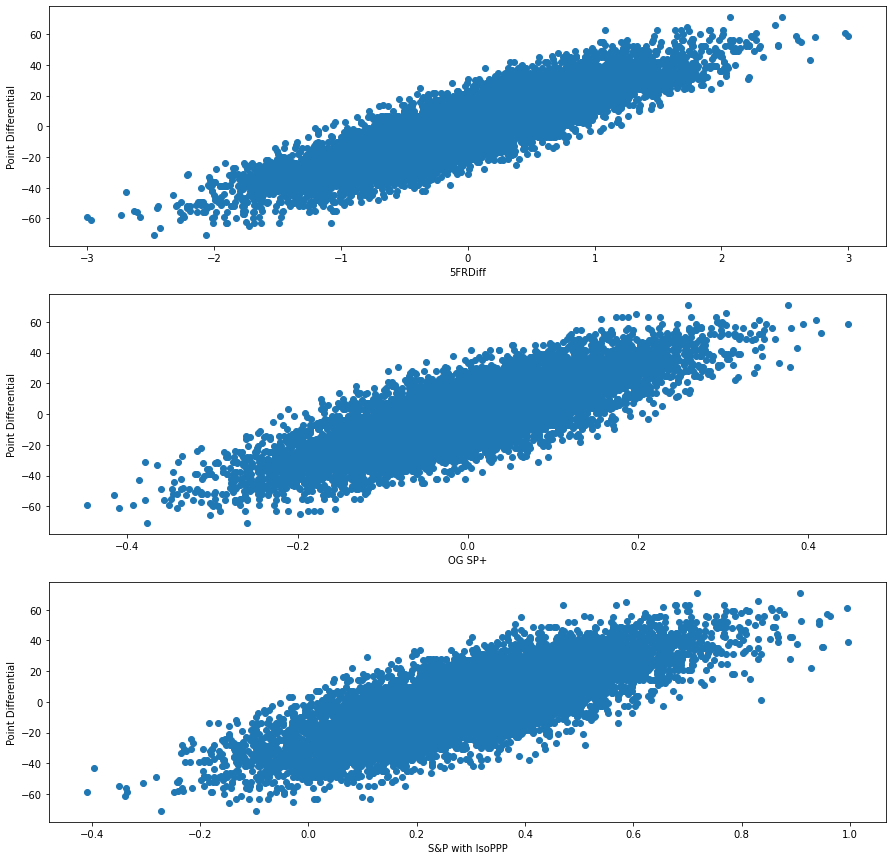

In [20]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [21]:
# fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
# fg.update_layout(
#     title="5FR Margin vs Point Margin (2012-2019)",
#     xaxis_title="5FR Margin",
#     yaxis_title="Point Margin")
# fg.show()
print("AVG MOV:", stored_game_boxes.PtsDiff.mean())
print("MOV STDDEV:", stored_game_boxes.PtsDiff.std())

AVG MOV: 0.0
MOV STDDEV: 20.95089456165382


In [22]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.949951,0.772435
S&PIsoPPPDiff,0.949951,1.000000,0.803297
PtsDiff,0.772435,0.803297,1.000000


In [23]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,67,0.492537,0.074627,6.029851,...,0.793388,-0.377277,-0.055340,0.512098,0.793388,-0.377277,5.292271,0.624742,0.841788,2.004783
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742,0.841788,2.004783
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487,0.763294,0.190932
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,59,0.271186,0.152542,5.813559,...,0.567014,0.931437,-1.336699,-0.905308,0.567014,0.931437,4.703257,-0.566487,0.763294,0.190932
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630,0.529036,0.525062


In [24]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [25]:
# outliers

In [26]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
1,Akron,2012,322432006,14.0,-42.0,0.203786,81,0.382716,0.061728,4.370370,...,-0.793388,0.377277,0.055340,-0.512098,-0.793388,0.377277,4.667529,-0.624742,0.841788,2.004783
2,South Carolina,2012,322430238,17.0,4.0,0.518995,62,0.435484,0.080645,5.129032,...,-0.567014,-0.931437,1.336699,0.905308,-0.567014,-0.931437,5.269743,0.566487,0.763294,0.190932
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,67,0.447761,0.134328,6.119403,...,-0.225997,-0.136838,1.198972,1.220103,-0.225997,-0.136838,4.803685,-0.392630,0.529036,0.525062
5,Ball State,2012,322432050,37.0,11.0,0.979920,96,0.510417,0.083333,6.291667,...,0.225997,0.136838,-1.198972,-1.220103,0.225997,0.136838,5.196315,0.392630,0.529036,0.525062
6,UCLA,2012,322430242,49.0,25.0,0.361313,69,0.536232,0.130435,9.173913,...,0.200629,-0.592460,1.088340,1.312536,0.200629,-0.592460,5.281189,0.609177,0.820815,1.193323


In [27]:
# Linear Regression Model
# from sklearn.linear_model import LinearRegression, SGDClassifier
# from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [33]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data["PtsDiff"][:, np.newaxis])

# print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Mean Pred Score: -0.16800160706043243
Pred Std Dev: 17.6263427734375
Mean Abs Error: 8.181205453500965
Mdn Abs Error: 6.762170791625977
R-squared: 0.7559479882361797
Adj R-squared: 0.7558266900195973



/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  from ipykernel import kernelapp as app
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is de

,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.759394,0.541259,0.465642,0.793180,0.593252,0.614415,0.982676,0.515201,0.762567,...,0.141352,0.102586,-0.051047,-0.178884,-0.141352,0.102586,-0.051047,0.871564,0.872962,0.869954
OffSRDiff,0.759394,1.000000,0.445660,0.277155,0.680981,0.373528,0.445229,0.754820,0.759227,0.701761,...,0.118135,0.089389,-0.054374,-0.128631,-0.118135,0.089389,-0.054374,0.960354,0.962742,0.958932
OffERDiff,0.541259,0.445660,1.000000,0.109480,0.471300,0.291511,0.330134,0.528863,0.324181,0.794341,...,0.120170,-0.001629,-0.091571,-0.119445,-0.120170,-0.001629,-0.091571,0.513723,0.514421,0.513318
FPDiff,0.465642,0.277155,0.109480,1.000000,0.584267,0.093936,0.065938,0.440800,0.049803,0.191625,...,0.067687,0.384932,0.249511,-0.159305,-0.067687,0.384932,0.249511,0.353809,0.354268,0.354703
OppRateDiff,0.793180,0.680981,0.471300,0.584267,1.000000,0.193805,0.203886,0.791546,0.265865,0.641211,...,0.141008,0.079161,-0.081813,-0.177590,-0.141008,0.079161,-0.081813,0.759722,0.760374,0.759037
OppEffDiff,0.593252,0.373528,0.291511,0.093936,0.193805,1.000000,0.767827,0.594601,0.454795,0.437523,...,0.059059,0.072965,0.023733,-0.066463,-0.059059,0.072965,0.023733,0.496409,0.497283,0.490493
OppPPDDiff,0.614415,0.445229,0.330134,0.065938,0.203886,0.767827,1.000000,0.624193,0.567316,0.488716,...,0.069077,0.036077,-0.022017,-0.080517,-0.069077,0.036077,-0.022017,0.594623,0.596986,0.589139
PPDDiff,0.982676,0.754820,0.528863,0.440800,0.791546,0.594601,0.624193,1.000000,0.514205,0.753190,...,0.139172,0.099704,-0.066340,-0.174978,-0.139172,0.099704,-0.066340,0.869872,0.871181,0.867713
OppSRDiff,0.515201,0.759227,0.324181,0.049803,0.265865,0.454795,0.567316,0.514205,1.000000,0.533684,...,0.051912,0.063238,-0.012359,-0.056545,-0.051912,0.063238,-0.012359,0.743320,0.746138,0.739799
YPPDiff,0.762567,0.701761,0.794341,0.191625,0.641211,0.437523,0.488716,0.753190,0.533684,1.000000,...,0.134763,0.028918,-0.093039,-0.135998,-0.134763,0.028918,-0.093039,0.774309,0.776303,0.774347


In [34]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.761705,0.759394,0.756339,0.907282,0.312592,0.419298,0.871564,0.872962,0.869954
ActPts,0.761705,1.000000,0.591181,0.585159,0.694580,0.233688,0.313465,0.672534,0.675334,0.673966
Eff,0.759394,0.591181,1.000000,0.695339,0.797872,0.317908,0.279959,0.960354,0.962742,0.958932
Expl,0.756339,0.585159,0.695339,1.000000,0.740942,0.267686,0.244755,0.769276,0.770851,0.767973
FinDrv,0.907282,0.694580,0.797872,0.740942,1.000000,0.304895,0.378692,0.921732,0.923940,0.917702
FldPos,0.312592,0.233688,0.317908,0.267686,0.304895,1.000000,0.082593,0.354091,0.354492,0.355114
Trnovr,0.419298,0.313465,0.279959,0.244755,0.378692,0.082593,1.000000,0.422074,0.377532,0.377405
5FR,0.871564,0.672534,0.960354,0.769276,0.921732,0.354091,0.422074,1.000000,0.997659,0.993027
5FRDiff,0.872962,0.675334,0.962742,0.770851,0.923940,0.354492,0.377532,0.997659,1.000000,0.995356
PredPtsDiff,0.869954,0.673966,0.958932,0.767973,0.917702,0.355114,0.377405,0.993027,0.995356,1.000000


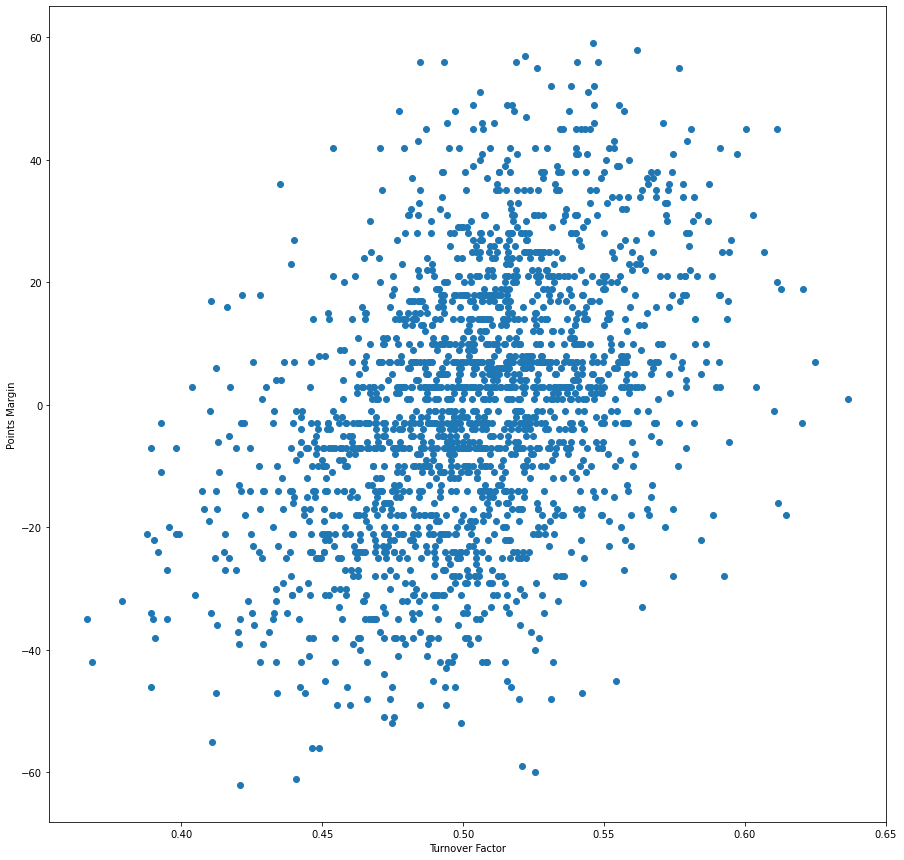

In [35]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

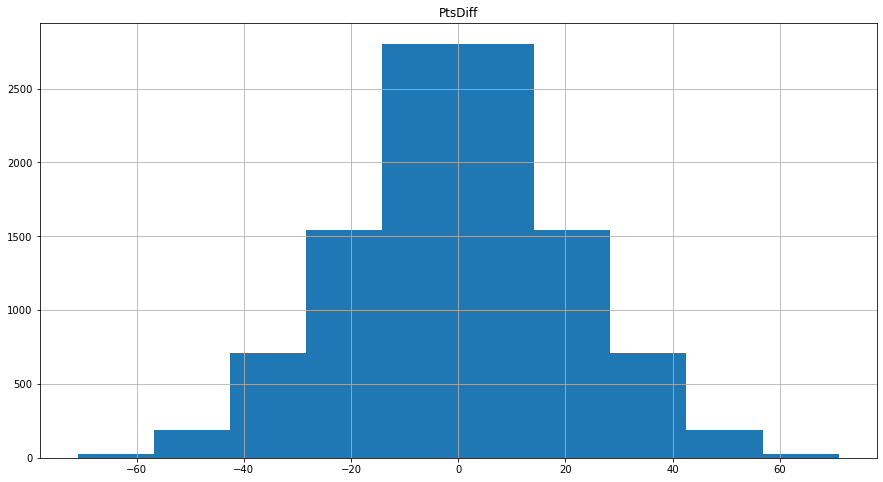

In [36]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

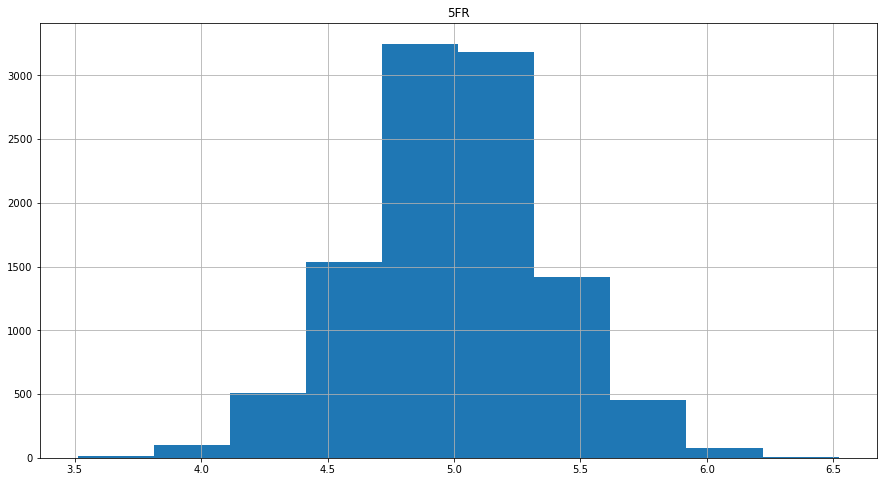

In [37]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

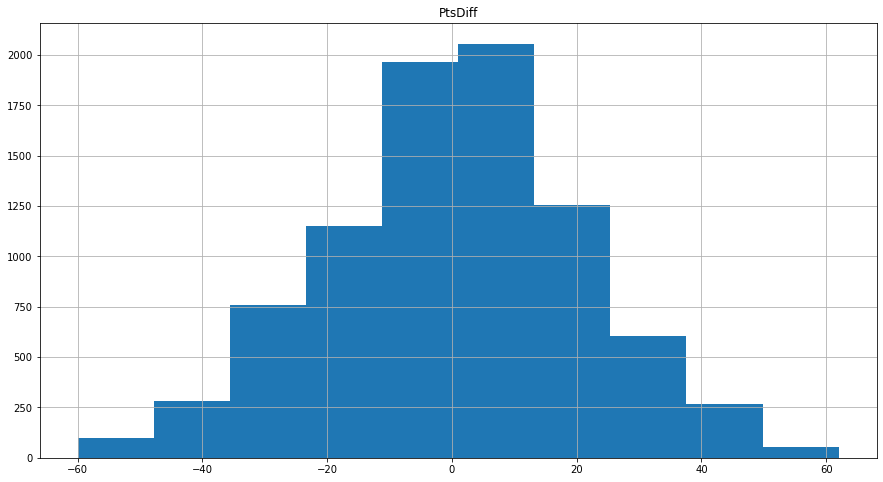

In [38]:
train_data.hist(column='PtsDiff', figsize=(15,8));

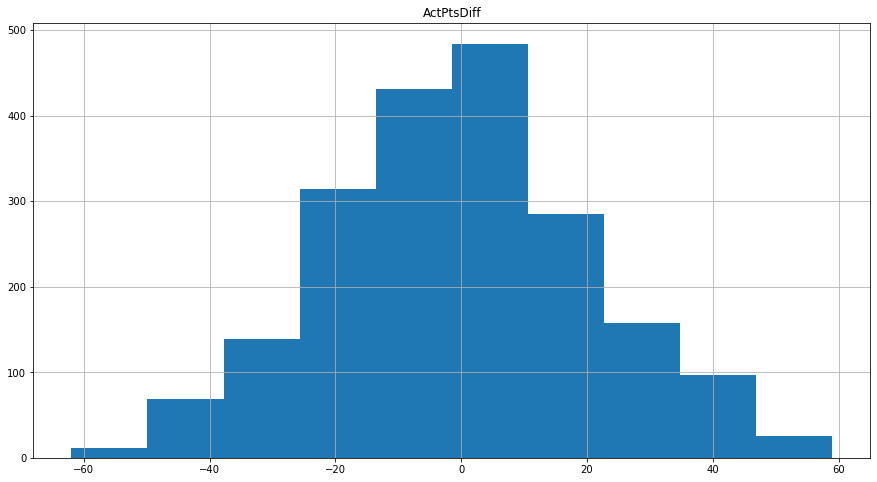

In [39]:
test.hist(column='ActPtsDiff', figsize=(15,8));

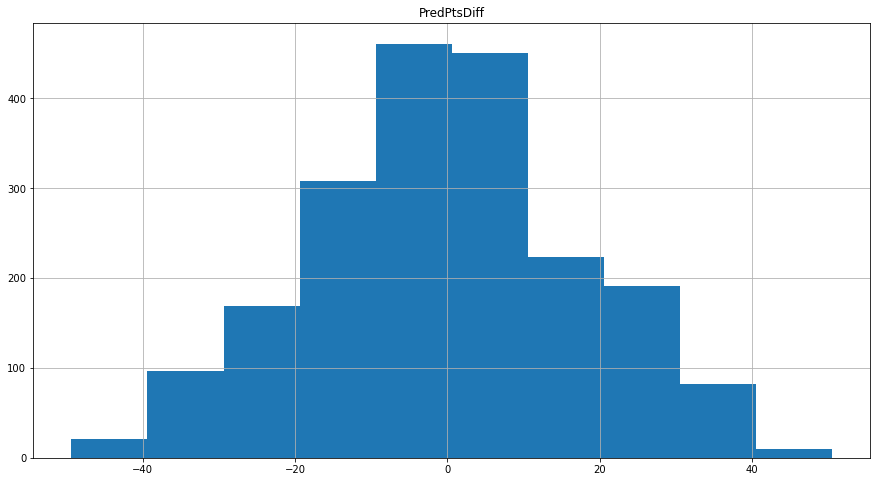

In [40]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [41]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [42]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4 (exact value: -3.550262451171875)
Z score: -0.19188670814037323
Win Prob for Virginia Tech: 42.39%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,63,0.396825,0.111111,6.507937,...,-1.277747,-1.277747,-0.351533,-0.074169,1.277747,1.277747,-0.351533,-0.074169,5.097129,0.195486
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,76,0.368421,0.078947,5.513158,...,1.277747,1.277747,0.351533,0.074169,-1.277747,-1.277747,0.351533,0.074169,4.901643,-0.195486


In [43]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -2 (exact value: -1.9402270317077637)
Z score: -0.10054413229227066
Win Prob for Georgia Tech: 46.00%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,63,0.396825,0.111111,5.460317,...,-0.933098,-1.377563,-1.340971,-1.271901,0.933098,1.377563,-1.340971,-1.271901,5.000088,-0.045422
1,Miami,2019,401112488,21.0,-7.0,0.934248,62,0.370968,0.112903,5.790323,...,0.933098,1.377563,1.340971,1.271901,-0.933098,-1.377563,1.340971,1.271901,5.045510,0.045422


In [44]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -3 (exact value: -2.9411633014678955)
Z score: -0.15733051300048828
Win Prob for Georgia Tech: 43.75%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,80,0.487500,0.150000,5.712500,...,-0.897603,-1.173665,-0.611488,-0.611488,0.897603,1.173665,-0.611488,-0.611488,5.036152,0.073397
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,57,0.473684,0.140351,7.035088,...,0.897603,1.173665,0.611488,0.611488,-0.897603,-1.173665,0.611488,0.611488,4.962754,-0.073397


In [45]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 2 (exact value: 1.7293744087219238)
Z score: 0.10764434188604355
Win Prob for Mississippi State: 54.29%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,71,0.422535,0.070423,5.563380,...,-0.882085,-0.987754,0.250056,0.379959,0.882085,0.987754,0.250056,0.379959,4.967197,-0.040973
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,58,0.413793,0.137931,5.482759,...,0.882085,0.987754,-0.250056,-0.379959,-0.882085,-0.987754,-0.250056,-0.379959,5.008170,0.040973


In [46]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -3 (exact value: -3.3158183097839355)
Z score: -0.17858591675758362
Win Prob for Texas A&M: 42.91%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,90,0.466667,0.088889,5.511111,...,-1.387078,-1.436023,-0.277088,0.436788,1.387078,1.436023,-0.277088,0.436788,5.081001,0.162617
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,104,0.423077,0.105769,4.634615,...,1.387078,1.436023,0.277088,-0.436788,-1.387078,-1.436023,0.277088,-0.436788,4.918383,-0.162617


In [50]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(np.array([[tester['5FRDiff'].mean()]]))
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,LSU,0.947942,13,12.0,1.0
2,Ohio State,0.947942,13,12.0,1.0
3,Alabama,0.935194,12,11.0,1.0
4,Clemson,0.902191,13,12.0,1.0
5,Oklahoma,0.891246,13,12.0,1.0
...,...,...,...,...,...
126,Maryland,0.090304,12,1.0,11.0
127,Akron,0.080468,12,1.0,11.0
128,Bowling Green,0.051380,12,1.0,11.0
129,UMass,0.051380,12,1.0,11.0


In [51]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/akeaswaran/anaconda3/lib/python3.7/site

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/akeaswaran/anaconda3/lib/python3.7/site

,team,second_order_wins,second_order_losses
53,LSU,10.749884,2.250116
77,Ohio State,10.680654,2.319346
78,Oklahoma,9.630397,3.369603
75,Notre Dame,8.313398,3.686602
115,Utah,8.270949,4.729051
...,...,...,...
25,Connecticut,1.881664,10.118336
1,Akron,1.753681,10.246319
112,UMass,1.303874,10.696126
14,Bowling Green,1.114253,10.885747


In [52]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2021):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Florida State,2012,5.424575,1
1,Alabama,2012,5.399574,2
2,Arizona State,2012,5.336245,3
3,Notre Dame,2012,5.278415,4
4,Georgia,2012,5.248564,5
...,...,...,...,...
1098,East Carolina,2020,4.591110,71
1099,Vanderbilt,2020,4.578394,72
1100,Louisiana Monroe,2020,4.552368,73
1101,Syracuse,2020,4.517528,74


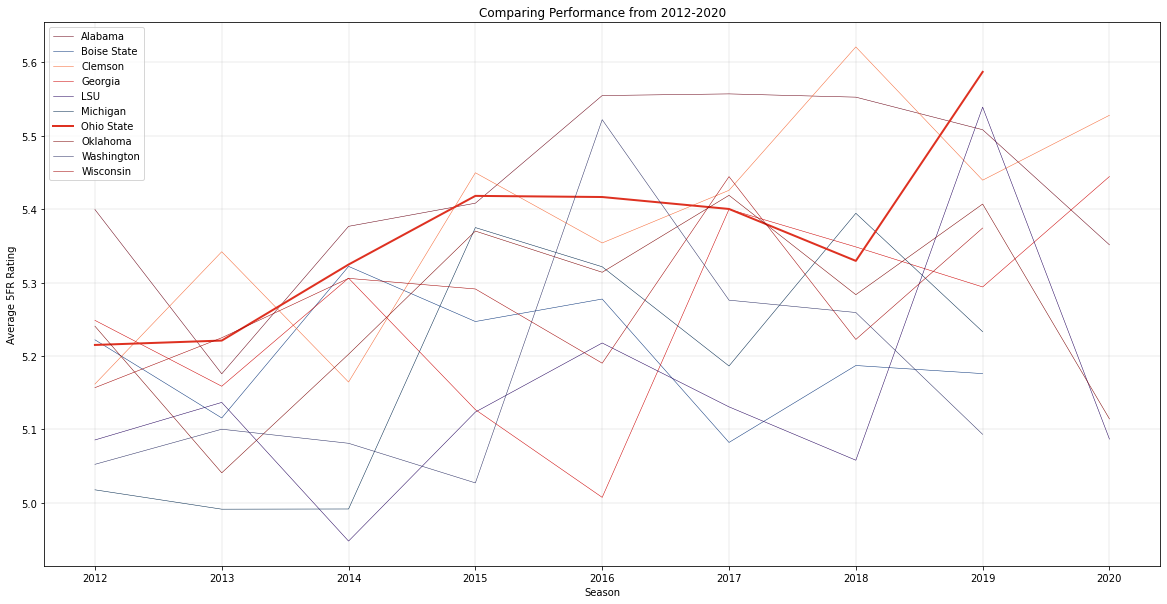

In [53]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [54]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.431628
1,Clemson,5.387395
2,Ohio State,5.364059
3,Wisconsin,5.276272
4,Oklahoma,5.265740
...,...,...
125,Connecticut,4.761715
126,UTEP,4.760347
127,UMass,4.753680
128,New Mexico State,4.751420


In [55]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
1028,Air Force,2020,5.821850,1
1029,BYU,2020,5.761986,2
768,Clemson,2018,5.621188,1
1030,Appalachian State,2020,5.596522,3
898,Ohio State,2019,5.587154,1
638,Alabama,2017,5.557155,1
510,Alabama,2016,5.554906,1
769,Alabama,2018,5.552709,2
126,Florida State,2013,5.542778,1
899,LSU,2019,5.539098,2


In [56]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
276,Georgia Tech,2014,5.163879,23
1055,Georgia Tech,2020,5.096640,28
53,Georgia Tech,2012,5.034246,54
723,Georgia Tech,2017,4.959406,86
207,Georgia Tech,2013,4.915070,82
857,Georgia Tech,2018,4.905974,90
598,Georgia Tech,2016,4.900641,89
467,Georgia Tech,2015,4.895461,86
998,Georgia Tech,2019,4.846594,101


In [57]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
...,...,...,...,...,...
10246,401117533.0,Nevada,2019.0,Wyoming,7.0
10247,401117541.0,Boise State,2019.0,Wyoming,8.0
10248,401117546.0,Utah State,2019.0,Wyoming,9.0
10249,401117550.0,Colorado State,2019.0,Wyoming,10.0


In [60]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False, adjust_covid = False):
    considered_weeks = week
    if (week <= 0):
        considered_weeks = 16 # consider all weeks
    
    applied_year = year
    if (week == 0):
        applied_year = applied_year - 1 
        
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == applied_year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == applied_year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    fcs_talent = calculate_fcs_talent(year)
    fcs_old_talent = calculate_fcs_talent(applied_year)
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    # Generate comparison attributes for team 1
    team1_talent = fcs_talent
    team1_old_talent = fcs_old_talent
    team1_avg_ffr = grouped_by_year.get_group((team1, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team1, applied_year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference) if (len(team1_record.conference) > 0) else "fcs"
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_talent = fcs_talent
        team1_old_talent = fcs_old_talent
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_talent = calculate_roster_talent(team1, year)
        team1_old_talent = calculate_roster_talent(team1, applied_year)
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_talent = fcs_talent
    team2_old_talent = fcs_old_talent
    team2_avg_ffr = grouped_by_year.get_group((team2, applied_year))[:considered_weeks]['5FR'].tail(games_to_consider).mean() if ((team2, applied_year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference) if (len(team2_record.conference) > 0) else "fcs"
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < considered_weeks) & (opponent_game_ids.Season == applied_year)][:considered_weeks].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
#         print("fcs")
        team2_talent = fcs_talent
        team2_old_talent = fcs_old_talent
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_talent = calculate_roster_talent(team2, year)
        team2_old_talent = calculate_roster_talent(team2, applied_year)
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == applied_year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == applied_year)]['5FR'].mean()
    
#     print("checker")
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if ((team1_conf != "FBS Independents") & (team2_conf != "FBS Independents")):
        if (team2_conf_sos < team1_conf_sos):
            team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
        elif (team2_conf_sos > team1_conf_sos):
            team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)

    if (week < 5):
        # adjust by returning production  
        team1_ret_prod = calculate_returning_production(team1, year) * team1_talent
        team2_ret_prod = calculate_returning_production(team2, year) * team2_talent
        if (team2_ret_prod < team1_ret_prod):
            team2_avg_ffr *= (team2_talent / team1_talent)
        elif (team2_ret_prod > team1_ret_prod):
            team1_avg_ffr *= (team1_talent / team2_talent)
        
#         print("preseason")
#         print(team1, team1_ret_prod)
#         print(team2, team2_ret_prod)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(team1, team1_avg_ffr)
#     print(team2, team2_avg_ffr)
    pred = model.predict(np.array([[ffr_diff]]))
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += (1.0 if (adjust_covid) else 2.5)
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2020, 0, -1, True)

[0.10464045468528138, -22.29867172241211]

In [61]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019, -1, 4, False)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,home_point_diff,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick,ml_win,ats_win
0,Buffalo,Charlotte,7.0,24,5.941104,0.635550,False,Buffalo,Charlotte,Buffalo,Buffalo
0,Utah State,Kent State,7.0,-10,2.733099,0.565366,False,Utah State,Kent State,Kent State,Kent State
0,San Diego State,Central Michigan,3.5,37,-9.954798,0.289366,False,Central Michigan,Central Michigan,San Diego State,San Diego State
0,Georgia Southern,Liberty,4.5,-7,1.496368,0.537614,False,Georgia Southern,Liberty,Liberty,Liberty
0,SMU,Florida Atlantic,7.0,-14,-9.954798,0.289366,False,Florida Atlantic,Florida Atlantic,Florida Atlantic,Florida Atlantic
0,Florida International,Arkansas State,1.0,-6,-3.315818,0.429131,False,Arkansas State,Arkansas State,Arkansas State,Arkansas State
0,Washington,Boise State,3.5,31,-1.940227,0.459956,False,Boise State,Boise State,Washington,Washington
0,Appalachian State,UAB,17.0,14,9.500940,0.708343,False,Appalachian State,UAB,Appalachian State,UAB
0,UCF,Marshall,15.0,23,5.077344,0.616990,False,UCF,Marshall,UCF,UCF
0,BYU,Hawai'i,2.0,-4,3.279031,0.577523,True,BYU,BYU,Hawai'i,Hawai'i


In [62]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 19-21
ML Record: 23-17


In [63]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 2 (exact value: 2.01633882522583)
Z score: 0.12392476946115494
Win Prob for Virginia: 54.93%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,74,0.432432,0.162162,6.540541,...,-0.910587,-1.140793,1.056893,0.157436,0.910587,1.140793,1.056893,0.157436,4.950479,-0.058095
1,Virginia,2019,401112521,39.0,9.0,0.422744,55,0.381818,0.181818,8.872727,...,0.910587,1.140793,-1.056893,-0.157436,-0.910587,-1.140793,-1.056893,-0.157436,5.008574,0.058095


In [64]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13 (exact value: 12.809738159179688)
Z score: 0.7362695336341858
Win Prob for North Carolina: 76.92%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,94,0.457447,0.106383,5.744681,...,-1.062832,-1.471232,0.192298,0.494556,1.062832,1.471232,0.192298,0.494556,5.194658,0.367629
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,53,0.396226,0.150943,6.094340,...,1.062832,1.471232,-0.192298,-0.494556,-1.062832,-1.471232,-0.192298,-0.494556,4.827029,-0.367629


In [65]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 18 (exact value: 17.83392906188965)
Z score: 1.0213083028793335
Win Prob for Pittsburgh: 84.64%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,69,0.362319,0.057971,5.086957,...,-0.956935,-0.956935,-0.532462,-0.482748,0.956935,0.956935,-0.532462,-0.482748,5.368209,0.771879
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,49,0.204082,0.061224,3.591837,...,0.956935,0.956935,0.532462,0.482748,-0.956935,-0.956935,0.532462,0.482748,4.596329,-0.771879


In [66]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -12 (exact value: -11.640815734863281)
Z score: -0.6508902311325073
Win Prob for Auburn: 25.76%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,75,0.453333,0.133333,6.440000,...,-0.043214,-0.779818,-1.698095,-1.512325,0.043214,0.779818,-1.698095,-1.512325,5.23668,0.49139
1,Auburn,2019,401110865,48.0,3.0,0.599891,62,0.338710,0.112903,5.322581,...,0.043214,0.779818,1.698095,1.512325,-0.043214,-0.779818,1.698095,1.512325,4.74529,-0.49139


In [67]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 33 (exact value: 33.355796813964844)
Z score: 1.9019147157669067
Win Prob for Georgia: 97.14%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,Plays,OffSR,OffER,YPP,...,KickoffEqPPPDiff,KickoffIsoPPPDiff,PuntEqPPPDiff,PuntIsoPPPDiff,KickoffReturnEqPPPDiff,KickoffReturnIsoPPPDiff,PuntReturnEqPPPDiff,PuntReturnIsoPPPDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,72,0.472222,0.138889,6.847222,...,0.688628,NaN,0.831684,0.594622,-0.688628,-0.660553,0.831684,0.594622,5.707078,1.386026
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,58,0.224138,0.034483,2.396552,...,-0.688628,NaN,-0.831684,-0.594622,0.688628,0.660553,-0.831684,-0.594622,4.321052,-1.386026


In [68]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row):
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4,(row.Site != "Neutral"))[0]
    if (row.Team == row.HomeTeam):
        return prob
    else:
        return 1-prob

def clean_prediction_mov(row):
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Year, row.name, 4, (row.Site != "Neutral"))[1]
    if (row.Team == row.HomeTeam):
        return mov
    else:
        return -1 * mov

def determine_site(row):
    if (row.NeutralSite):
        return "Neutral"
    elif (row.HomeTeam == row.Team):
        return "Home"
    else:
        return "Away"
    
    
def generate_schedule_analysis(team, year = 2019):
    gms = games[(games.year == year) & ((games.away_team == team) | (games.home_team == team))]
    frame = pd.DataFrame(data={"GameID":gms.id,"Year":year,"Team":team,"AwayTeam":gms.away_team,"HomeTeam":gms.home_team,"NeutralSite":gms.neutral_site})
    frame.reset_index(inplace=True, drop=True)
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['Site'] = frame.apply(lambda y: determine_site(y), axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(y), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(y) * 100, axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame[["GameID","Year","Team","Opponent","Site","PredMOV","PredWinProb","ActualMOV","PostGameWinProb"]]

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 22 (exact value: 21.56852149963379)
Z score: 1.2331839799880981
Win Prob for Clemson: 89.12%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 12 (exact value: 11.552593231201172)
Z score: 0.6649476289749146
Win Prob for Georgia Tech: 74.70%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -4 (exact value: -3.550262451171875)
Z score: -0.19188670814037323
Win Prob for The Citadel: 42.39%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 18 (exact value: 17.83392906188965)
Z score: 1.0213083028793335
Win Prob for Temple: 84.64%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13 (exact value: 12.809738159179688)
Z score: 0.7362695336341858
Win Prob for North Carolina: 76.92%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Duke
Actual Winner: Duke
MOV: Duke by 18.0
Proj MOV: Duke by 11 (exact value: 10.664244651794434)
Z score: 0.6145486831665039
Win Prob for Duke: 73.06%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -2 (exact value: -1.9402270317077637)
Z score: -0.10054413229227066
Win Prob for Georgia Tech: 46.00%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 18 (exact value: 17.83392906188965)
Z score: 1.0213083028793335
Win Prob for Pittsburgh: 84.64%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 5.0
Proj MOV: Virginia by 3 (exact value: 3.2790310382843018)
Z score: 0.19556142389774323
Win Prob for Virginia: 57.75%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Virginia Tech @ Georgia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 45.0
Proj MOV: Virginia Tech by 47 (exact value: 47.2978630065918)
Z score: 2.6928937435150146
Win Prob for Virginia Tech: 99.65%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -3 (exact value: -2.9411633014678955)
Z score: -0.15733051300048828
Win Prob for Georgia Tech: 43.75%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 33 (exact value: 33.355796813964844)
Z score: 1.9019147157669067
Win Prob for Georgia: 97.14%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


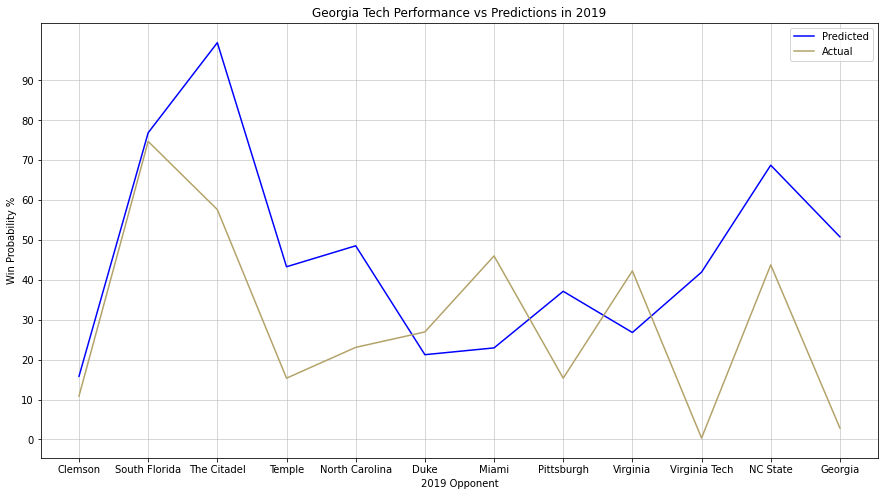

In [69]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

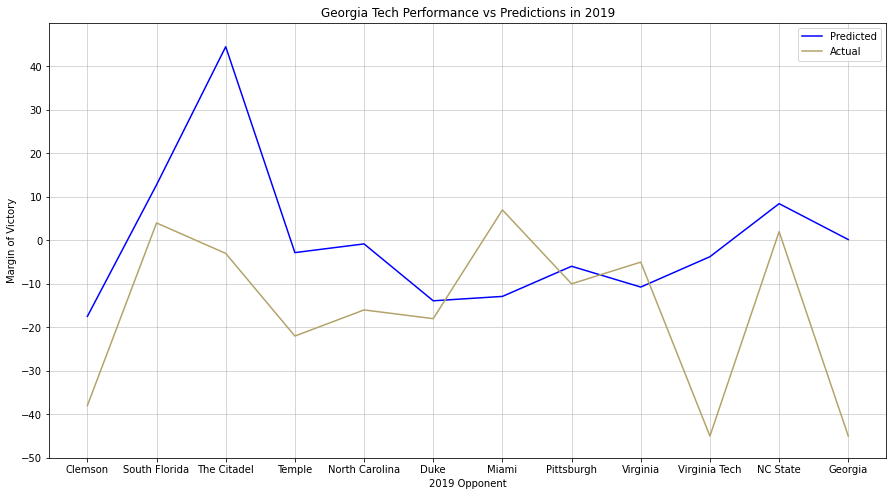

In [70]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 39 (exact value: 39.0521125793457)
Z score: 2.2250852584838867
Win Prob for Georgia Tech: 98.70%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 4 (exact value: 3.5050432682037354)
Z score: 0.20838384330272675
Win Prob for South Florida: 58.25%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 3 (exact value: 3.2790310382843018)
Z score: 0.19556142389774323
Win Prob for Pittsburgh: 57.75%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 36 (exact value: 35.840450286865234)
Z score: 2.042877197265625
Win Prob for Clemson: 97.95%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 32 (exact value: 31.946826934814453)
Z score: 1.8219791650772095
Win Prob for Georgia Tech: 96.58%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Louisville
Actual Winner: Georgia Tech
MOV: Georgia Tech by 35.0
Proj MOV: Georgia Tech by 32 (exact value: 31.62144660949707)
Z score: 1.8035192489624023
Win Prob for Georgia Tech: 96.43%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Duke @ Georgia Tech
Actual Winner: Duke
MOV: Duke by 14.0
Proj MOV: Duke by 13 (exact value: 13.4310884475708)
Z score: 0.7715207934379578
Win Prob for Duke: 77.98%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Virginia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 21.0
Proj MOV: Georgia Tech by 13 (exact value: 13.040227890014648)
Z score: 0.7493459582328796
Win Prob for Georgia Tech: 77.32%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ North Carolina
Actual Winner: Georgia Tech
MOV: Georgia Tech by 10.0
Proj MOV: Georgia Tech by 10 (exact value: 10.388333320617676)
Z score: 0.5988953113555908
Win Prob for Georgia Tech: 72.54%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Miami @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 6.0
Proj MOV: Georgia Tech by -3 (exact value: -3.3158183097839355)
Z score: -0.17858591675758362
Win Prob for Georgia Tech: 42.91%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Virginia @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by -7 (exact value: -7.106948375701904)
Z score: -0.39366909861564636
Win Prob for Georgia Tech: 34.69%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Georgia
Actual Winner: Georgia
MOV: Georgia by 24.0
Proj MOV: Georgia by 32 (exact value: 31.946826934814453)
Z score: 1.8219791650772095
Win Prob for Georgia: 96.58%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


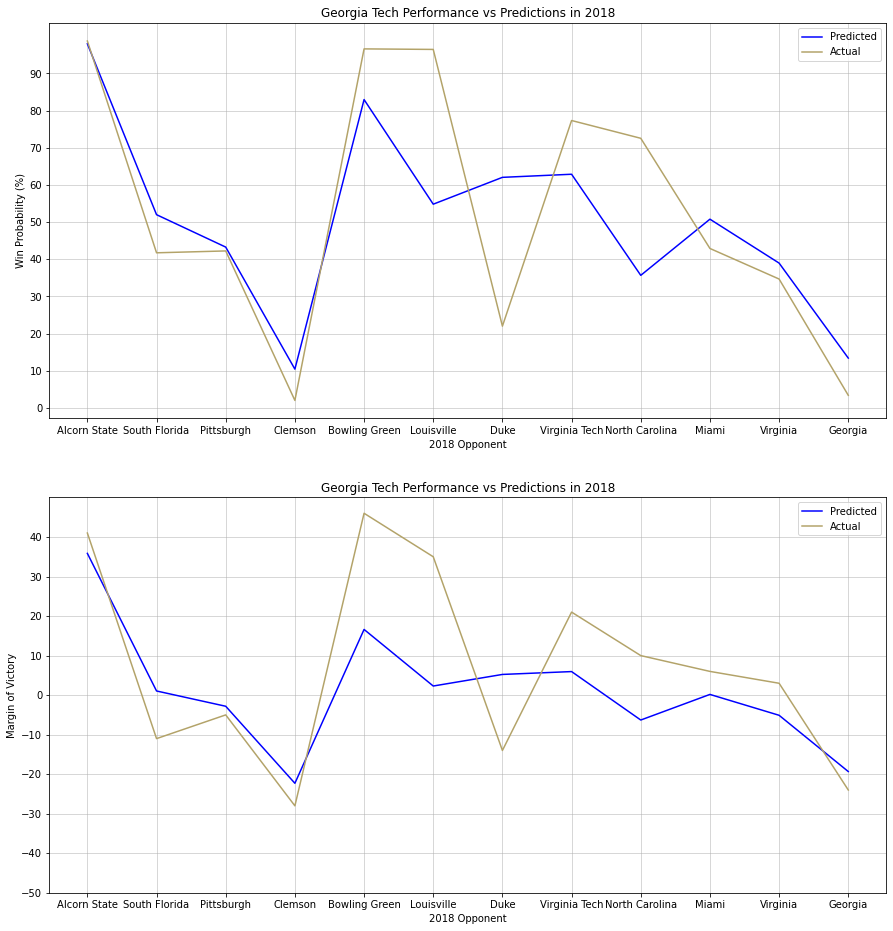

In [71]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability (%)')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

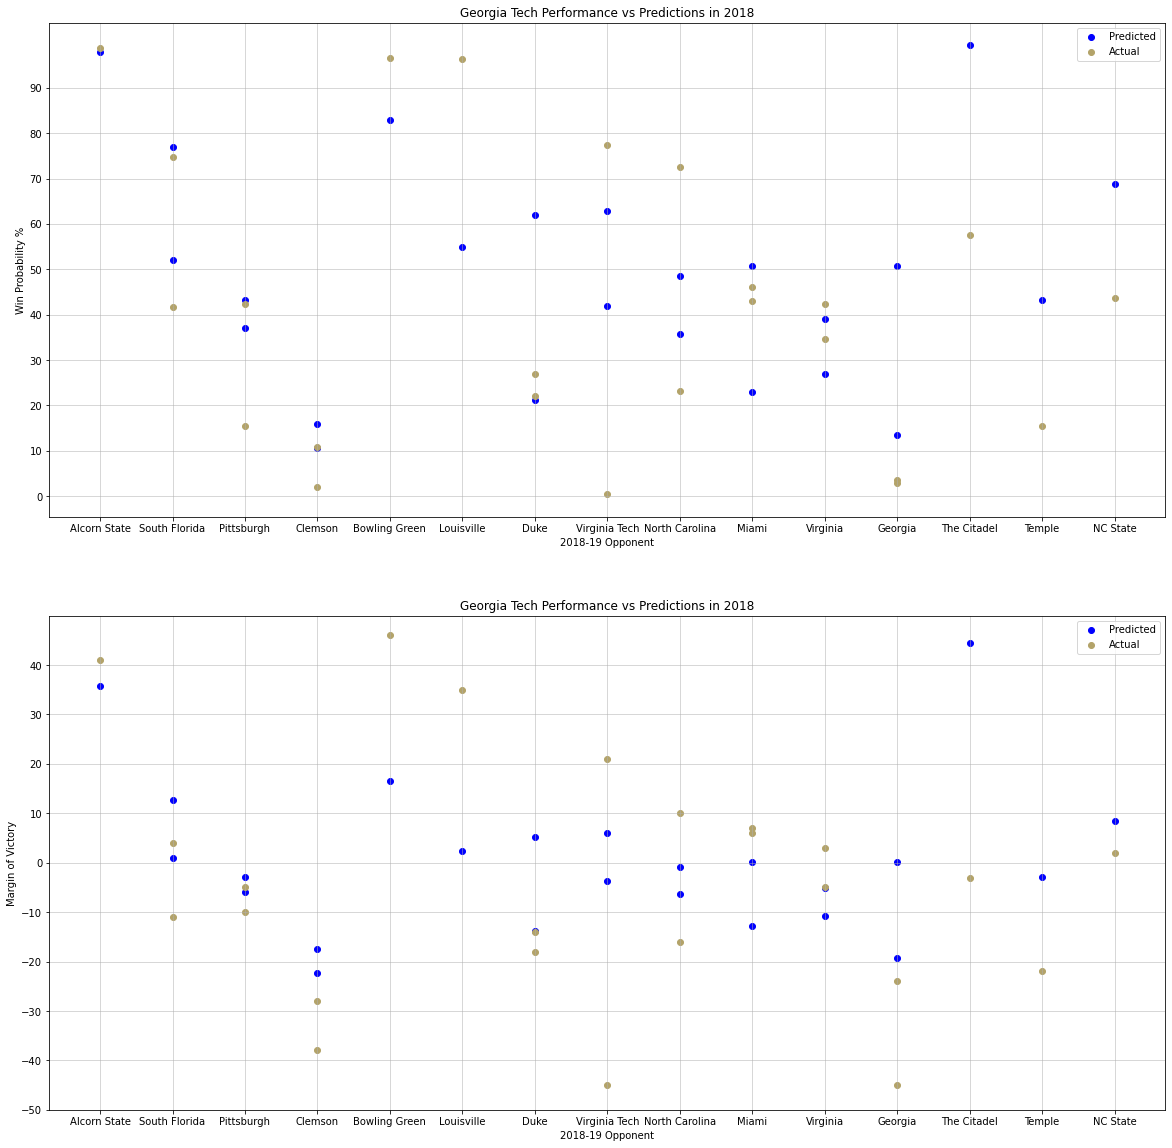

In [72]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [73]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019,2020
Season,,,,,,,,,
2012,1.000000,0.589968,0.433165,0.413175,0.319913,0.257924,0.252010,0.304181,0.266783
2013,0.589968,1.000000,0.509891,0.345305,0.232832,0.259887,0.200100,0.288702,0.023358
2014,0.433165,0.509891,1.000000,0.539923,0.377669,0.301211,0.283678,0.327604,0.130324
2015,0.413175,0.345305,0.539923,1.000000,0.605279,0.423373,0.338788,0.365003,0.323557
2016,0.319913,0.232832,0.377669,0.605279,1.000000,0.533999,0.343896,0.481320,0.298611
2017,0.257924,0.259887,0.301211,0.423373,0.533999,1.000000,0.597994,0.492423,0.329443
2018,0.252010,0.200100,0.283678,0.338788,0.343896,0.597994,1.000000,0.559105,0.419068
2019,0.304181,0.288702,0.327604,0.365003,0.481320,0.492423,0.559105,1.000000,0.418965
2020,0.266783,0.023358,0.130324,0.323557,0.298611,0.329443,0.419068,0.418965,1.000000


In [74]:
def round_sig_figs(i, n):
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

def clean_prediction_prob_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    prob = predict_matchup(home_team, away_team, row.Year, 0, -1,(row.Site != "Neutral"), True)[0]
    if (row.Team == home_team):
        return prob
    else:
        return 1-prob

def clean_prediction_mov_names(row):
    away_team = row.Opponent if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Team
    home_team = row.Team if ((row.Site == "Home") | (row.Site == "Neutral")) else row.Opponent
#     print(away_team, home_team)
    mov = predict_matchup(home_team, away_team, row.Year, 0, -1, (row.Site != "Neutral"), True)[1]
    if (row.Team == home_team):
        return mov
    else:
        return -1 * mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame

opp_2020_df = pd.DataFrame(data={
    "Team" : ["Florida State","UCF","Syracuse","Louisville","Clemson","Boston College","Notre Dame","Pittsburgh","Miami","Duke","NC State"],
    "Site" : ["Away","Home","Away","Home","Home","Away","Home","Home","Away","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
# georgia_tech_2020.to_csv("results/gt-2020.csv", index=False, sep=",")
print(f"Expected 2nd order wins: {georgia_tech_2020.PredWinProb.sum() / 100}")
georgia_tech_2020

Expected 2nd order wins: 4.022554546665681


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Florida State,Away,25.603155,-11.388333
1,2020,Georgia Tech,UCF,Home,45.150786,-2.315818
2,2020,Georgia Tech,Syracuse,Away,52.607253,1.320777
3,2020,Georgia Tech,Louisville,Home,48.629817,-0.773504
4,2020,Georgia Tech,Clemson,Home,9.001785,-23.798672
5,2020,Georgia Tech,Boston College,Away,48.389769,-0.543635
6,2020,Georgia Tech,Notre Dame,Home,16.055625,-17.656406
7,2020,Georgia Tech,Pittsburgh,Home,38.638518,-5.257662
8,2020,Georgia Tech,Miami,Away,23.795470,-12.397768
9,2020,Georgia Tech,Duke,Home,45.993509,-1.941163


In [75]:
opp_2019_df = pd.DataFrame(data={
    "Team" : ["Clemson","South Florida","The Citadel","Temple","North Carolina","Duke","Miami","Pittsburgh","Virginia","Virginia Tech","NC State","Georgia"],
    "Site" : ["Away","Home","Home","Away","Home","Away","Away","Home","Away","Home","Home","Home"]
})
georgia_tech_2019 = generate_schedule_predictions("Georgia Tech", opp_2019_df, 2019)
print(f"Expected 2nd order wins: {georgia_tech_2019.PredWinProb.sum() / 100}")
georgia_tech_2019

Expected 2nd order wins: 5.360946272884359


,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2019,Georgia Tech,Clemson,Away,20.376332,-14.431088
1,2019,Georgia Tech,South Florida,Home,56.007461,2.496368
2,2019,Georgia Tech,The Citadel,Home,97.492298,34.355797
3,2019,Georgia Tech,Temple,Away,41.242079,-3.733099
4,2019,Georgia Tech,North Carolina,Home,53.984000,1.595173
5,2019,Georgia Tech,Duke,Away,42.831800,-3.016339
6,2019,Georgia Tech,Miami,Away,40.040665,-4.279031
7,2019,Georgia Tech,Pittsburgh,Home,47.392747,-1.320777
8,2019,Georgia Tech,Virginia,Away,40.040665,-4.279031
9,2019,Georgia Tech,Virginia Tech,Home,48.252758,-0.940227


In [76]:
line_data = pd.DataFrame()

for i in range(2013, 2021):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    if "ï»¿id" in ln.columns:
        ln["id"] = ln["ï»¿id"]
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")
# print(f"2020 Spreads imported: {len(line_data[line_data.year == 2020].id.to_list())}")
# games[(games.id.isin(line_data[line_data.year == 2020].id.to_list()))].head()

Spreads imported: 19820


In [77]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else 0
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite), adjust_covid = (row.Season == 2020))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [78]:
historic_validation = pd.DataFrame()
for i in range(2013, 2021):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 604 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 597 games with betting lines for 2013 season.
[Simulation] Creating projections for 597 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 619 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 571 games with betting lines for 2014 season.
[Simulation] Creating projections for 571 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 662 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 632 games with betting lines for 2015 season.
[Simulation] Creating projections for 632 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,450,147,0,0.753769
1,ATS,2013,347,243,7,0.581240
0,ML,2014,428,143,0,0.749562
1,ATS,2014,341,216,14,0.597198
0,ML,2015,491,141,0,0.776899
1,ATS,2015,370,245,17,0.585443
0,ML,2016,478,147,0,0.764800
1,ATS,2016,383,225,17,0.612800
0,ML,2017,506,176,0,0.741935
1,ATS,2017,395,268,19,0.579179


In [79]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2020) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2020) if betting $5 per game: $3192.0


,pick_category,season,W,L,D,WinPct,total_invested,net_payout,avg_weekly_payout,pct_return
1,ATS,2013,347,243,7,0.581240,2985,398.5,24.906250,0.133501
1,ATS,2014,341,216,14,0.597198,2855,517.0,32.312500,0.181086
1,ATS,2015,370,245,17,0.585443,3160,502.5,33.500000,0.159019
1,ATS,2016,383,225,17,0.612800,3125,677.5,45.166667,0.216800
1,ATS,2017,395,268,19,0.579179,3410,501.0,33.400000,0.146921
1,ATS,2018,345,255,17,0.559157,3085,322.5,21.500000,0.104538
1,ATS,2019,376,289,11,0.556213,3380,290.5,19.366667,0.085947
1,ATS,2020,54,52,1,0.504673,535,-16.0,-1.066667,-0.029907


In [80]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7449455912891721
Avg ATS Win %: 0.5719878100353352


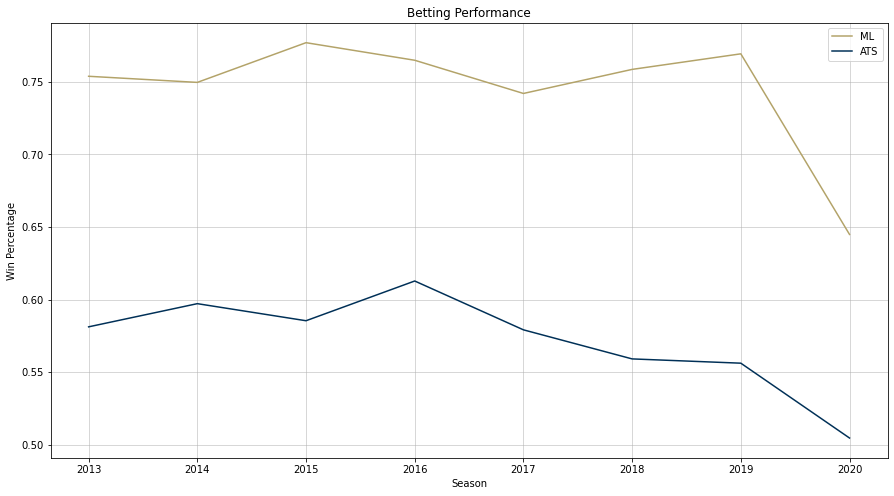

In [81]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

In [82]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [83]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.6320902677882521, 5.779031038284302]

In [84]:
# generate_win_prob(401135295, 2019)

In [85]:
# Rankings data
rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

Rankings imported: 11864


In [86]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

,Team,5FRSRS,5FRSRSRank
53,LSU,1.347937,1
77,Ohio State,1.168829,2
2,Alabama,1.103450,3
78,Oklahoma,0.870543,4
9,Auburn,0.861739,5
...,...,...,...
80,Old Dominion,-1.088773,125
25,Connecticut,-1.157937,126
14,Bowling Green,-1.518913,127
1,Akron,-1.608600,128


In [87]:
generate_win_prob(401234563, 2020)

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 10 (exact value: 10.388333320617676)
Z score: 0.5988953113555908
Win Prob for Georgia Tech: 72.54%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


[0.7253786508691296, 3.0]

In [88]:
generate_win_prob(401234568, 2020)

Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.048050880432129)
Z score: 0.46612346172332764
Win Prob for UCF: 67.94%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


[0.6794364347454346, 28.0]

In [89]:
generate_win_prob(401234594, 2020)

Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by 0 (exact value: 0.01788535714149475)
Z score: 0.010545974597334862
Win Prob for Syracuse: 50.42%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


[0.5042071571697985, 17.0]

In [90]:
generate_win_prob(401234601, 2020)

Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 14 (exact value: 13.89237117767334)
Z score: 0.7976908683776855
Win Prob for Georgia Tech: 78.75%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


[0.7874750478416227, 19.0]

In [91]:
predict_matchup("Houston", "BYU", 2020, 0, -1,True, True)

[0.5161023135312368, 0.5436351895332336]

In [92]:
preds_2020 = [
    ["Miami","Virginia",12],
    ["Texas","Baylor",10.5],
    ["BYU","Texas State",28],
    ["Michigan","Minnesota",3],
    ["Auburn","Ole Miss",3],
    ["Ohio State","Nebraska",26]
]

bets_2020 = pd.DataFrame()
for data in preds_2020:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    # preseason picks because not everyone has played games yet; otherwise week == 7; games to consider == 4
    predictor = predict_matchup(team1, team2, 2020, week = 0, games_to_consider = -1, adjust_hfa = True, adjust_covid = True)
    bets_2020 = bets_2020.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets_2020

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Virginia,12.0,9.021081,0.698930,False,Miami,Virginia
0,Texas,Baylor,10.5,7.744829,0.673256,False,Texas,Baylor
0,BYU,Texas State,28.0,11.274141,0.741879,False,BYU,Texas State
0,Michigan,Minnesota,3.0,11.388333,0.743968,True,Michigan,Michigan
0,Auburn,Ole Miss,3.0,12.552593,0.764755,True,Auburn,Auburn
0,Ohio State,Nebraska,26.0,23.719543,0.912326,False,Ohio State,Nebraska


In [93]:
line_data[line_data.year == 2020].head()


,id,homeTeam,homeScore,awayTeam,awayScore,lineProvider,overUnder,spread,formattedSpread,year,ï»¿id
0,401234576,Navy,3.0,BYU,55.0,Bovada,48.0,1.0,BYU -1.0,2020,401234576.0
1,401234576,Navy,3.0,BYU,55.0,Caesars,48.0,1.5,BYU -1.5,2020,401234576.0
2,401234576,Navy,3.0,BYU,55.0,consensus,48.5,1.0,BYU -1,2020,401234576.0
3,401234576,Navy,3.0,BYU,55.0,numberfire,48.5,1.5,BYU -1.5,2020,401234576.0
4,401234576,Navy,3.0,BYU,55.0,teamrankings,48.5,1.0,BYU -1,2020,401234576.0


In [97]:
sched_2020 = generate_schedule_analysis(team = "Georgia Tech", year = 2020)
sched_2020

Game: Georgia Tech @ Florida State
Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0
Proj MOV: Georgia Tech by 10 (exact value: 10.388333320617676)
Z score: 0.5988953113555908
Win Prob for Georgia Tech: 72.54%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: UCF @ Georgia Tech
Actual Winner: UCF
MOV: UCF by 28.0
Proj MOV: UCF by 8 (exact value: 8.048050880432129)
Z score: 0.46612346172332764
Win Prob for UCF: 67.94%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Syracuse
Actual Winner: Syracuse
MOV: Syracuse by 17.0
Proj MOV: Syracuse by 0 (exact value: 0.01788535714149475)
Z score: 0.010545974597334862
Win Prob for Syracuse: 50.42%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Louisville @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 19.0
Proj MOV: Georgia Tech by 14 (exact value: 13.89237117767334)
Z score: 0.7976908683776855
Win Prob for Georgia Tech: 78.75%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 66.0
Proj MOV: Clemson by 37 (exact value: 36.778446197509766)
Z score: 2.096092700958252
Win Prob for Clemson: 98.20%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ Boston College
Actual Winner: Boston College
MOV: Boston College by 21.0
Proj MOV: Boston College by 6 (exact value: 5.941103935241699)
Z score: 0.34658950567245483
Win Prob for Boston College: 63.56%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Notre Dame @ Georgia Tech
Actual Winner: Notre Dame
MOV: Notre Dame by 18.0
Proj MOV: Notre Dame by 17 (exact value: 16.82794952392578)
Z score: 0.964235782623291
Win Prob for Notre Dame: 83.25%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Duke @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 23.0
Proj MOV: Georgia Tech by 14 (exact value: 14.115392684936523)
Z score: 0.8103435635566711
Win Prob for Georgia Tech: 79.11%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Georgia Tech @ NC State
Actual Winner: NC State
MOV: NC State by 10.0
Proj MOV: NC State by -2 (exact value: -1.9402270317077637)
Z score: -0.10054413229227066
Win Prob for NC State: 46.00%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 14.0
Proj MOV: Pittsburgh by 8 (exact value: 8.237829208374023)
Z score: 0.4768902063369751
Win Prob for Pittsburgh: 68.33%
---


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


,GameID,Year,Team,Opponent,Site,PredMOV,PredWinProb,ActualMOV,PostGameWinProb
0,401234563,2020,Georgia Tech,Florida State,Away,-12.105832,24.310963,3.0,72.537865
1,401234568,2020,Georgia Tech,UCF,Home,4.229374,59.850428,-28.0,32.056357
2,401234594,2020,Georgia Tech,Syracuse,Away,8.872267,68.928384,-17.0,49.579284
3,401234601,2020,Georgia Tech,Louisville,Home,4.516339,60.478718,19.0,78.747505
4,401234610,2020,Georgia Tech,Clemson,Home,-16.027884,18.411790,-66.0,1.803698
5,401234617,2020,Georgia Tech,Boston College,Away,-0.559773,48.353274,-21.0,36.444987
6,401234626,2020,Georgia Tech,Notre Dame,Home,-7.565425,33.735962,-18.0,16.746386
7,401234652,2020,Georgia Tech,Duke,Home,5.779031,63.209027,23.0,79.112863
8,401234659,2020,Georgia Tech,NC State,Away,0.815818,51.465893,-10.0,54.004383
9,401261245,2020,Georgia Tech,Pittsburgh,Home,-0.815818,48.534107,-14.0,31.672015


In [98]:
print(f"Expected 2nd order wins: {sched_2020.PostGameWinProb.sum() / 100}")

Expected 2nd order wins: 4.527053427772595


In [96]:
model.save_model('pgwp_model.model')